## Project: Build a Traffic Sign Recognition Classifier


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "train.p"
validation_file= "valid.p"
testing_file = "test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
# First make sure the volume of data is correct
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))

n_train = len(y_train)
n_validation = len(y_valid)
n_test = len(y_test)

image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples = ", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples = ", n_test)
print("Image data shape = ", image_shape)
print("Number of classes = ", n_classes)

Number of training examples =  34799
Number of validation examples =  4410
Number of testing examples =  12630
Image data shape =  (32, 32, 3)
Number of classes =  43


### Include an Exploratory Visualization of the Dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

In [ ]:
import matplotlib.pyplot as plt

# Visualizations will be shown in the notebook.
%matplotlib inline

In [ ]:
# Look at the distribution of classes in the training, validation and test set
#
# result: found that the data is imbalanced

from collections import Counter
import numpy as np

print("Distribution of Training set:")

train_label_classes, num_of_train_labels = zip(*Counter(y_train).items())

indexes = np.arange(len(train_label_classes))
width = 1

plt.bar(indexes, num_of_train_labels, width)
plt.show()

print("Distribution of Validation set:")

valid_label_classes, num_of_valid_labels = zip(*Counter(y_valid).items())
plt.bar(indexes, num_of_valid_labels, width)
plt.show()

print("Distribution of Test set:")
test_label_classes, num_of_test_labels = zip(*Counter(y_test).items())
plt.bar(indexes, num_of_test_labels, width)
plt.show()

In [ ]:
# plot a random image
import random


index = random.randint(0, len(X_train))

print("random index: ", index)
print("image original size: ", train['sizes'][index][0], 'x', train['sizes'][index][1])
print("sign position in original image: ", train['coords'][index])

print("type of single image in X_train: ", type(X_train[index]))
print("type of single pixel intensity of one image in X_train: ", X_train[index].dtype)

coords = train['coords'][index]

# Can't use mpimg.imread directly read image from numpy.ndarray
# -> TypeError: Object does not appear to be a 8-bit string path or a Python file-like object
# ex. image = mpimg.imread(X_train[10000])

plt.figure(figsize=(1,1))

# interpolation='nearest' simply display the image without try to interpolate betwen pixels 
# if the display resolution is not the same as the image resolution (which is most often the case)
plt.imshow(X_train[index], interpolation='nearest')
print()
print("label of the picture: ", y_train[index])

In [ ]:
# plot a bunch of random images from all 43 classifications

# get the idea from the blog of Alex Staravoitau
# https://navoshta.com/traffic-signs-classification/

from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

col_width = max(len(name) for name in signnames)

for sign_class, sign_index, sign_count in zip(sign_classes, class_indices, class_counts):
    print("Class {}: {:<{}}  {} samples".format(sign_class, signnames[sign_class], col_width, sign_count))
    fig = plt.figure(figsize = (10, 1))
    random_indices = random.sample(range(sign_index, sign_index + sign_count), 10)
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.set_title(str(random_indices[i]))        
        axis.imshow(X_train[random_indices[i]])
    plt.show()
    print("--------------------------------------------------------------------------------------\n")

### Observed Results

From above, we know that the dataset we use is **imbalanced** and has images that **differ significantly in terms of contrast and brightness**

Because of such an imbalanced data, the great accuracy may skew in favor of few classes, and the result turned out to be a lie.

> According to ["8 Tactics to Combat Imbalanced Classes in Your Machine Learning Dataset"](http://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/), the article in the blog of  Dr. Jason Brownlee. 

> It's a good idea to **get more data** to **reduce the affect of imbalance**.

But before doing things like flipping, rotating, shifting, it would be better to tackle brightness problem first.
 

--- 
## Step2. Pre-process the Data Set

###  Tackle Brightness Problem

From the paper writed by [Pierre Sermanet and Yann LeCun](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), It tackle contrast problem by converting image from RGB to YUV colorspace. 

The Y channel is then preprocessed with global and local contrast normalization while U and V channels are left unchanged

Also the article implicitly reveal that the result about using grayscale images to classify bacically eqauls to RGB images.


From [this post](https://read01.com/0MOGzg.html). I got the idea that the importance of YUV colorspace is 
that it can seperate luminance signal (Y) and chrominance signal (U, V). So, if we only take Y component, the image convert to grayscale, and fortunately that's what Opencv function cv2.RGB2GRAY() exactly does for us.

(YUV色彩空間的重要性是它的亮度信號Y和色度信號U、V是分離的, 如果只有Y信號分量而沒有U、V分量， 那麼這樣表示的圖就是黑白灰度圖。)

    
> From Wiki of YUV,

> + Y = 0.299 * R + 0.587 * G + 0.114 * B
> + U = 0.492 * (B - Y)
> + V = 0.877 * (R - Y)

After converting to grayscale, I apply local histogram equalization to stretch out the contrast of the image


In [ ]:
import cv2
def grayscale_and_adaptive_histogram_equalization(dataset):
    new_dataset = []
    for img in dataset:
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply local histogram equalization
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img = clahe.apply(img)
        new_dataset.append(img)
    return np.array(new_dataset).reshape(dataset.shape[0], dataset.shape[1], dataset.shape[2], 1)

X_train = grayscale_and_adaptive_histogram_equalization(X_train)
X_valid = grayscale_and_adaptive_histogram_equalization(X_valid)
X_test = grayscale_and_adaptive_histogram_equalization(X_test)

In [ ]:
from pandas.io.parsers import read_csv
import random

signnames = read_csv("signnames.csv").values[:, 1]
sign_classes, class_indices, class_counts = np.unique(y_train, return_index = True, return_counts = True)

col_width = max(len(name) for name in signnames)


for sign_class, sign_index, sign_count in zip(sign_classes, class_indices, class_counts):
    print("Class {}: {:<{}}  {} samples".format(sign_class, signnames[sign_class], col_width, sign_count))
    fig = plt.figure(figsize = (10, 1))
    random_indices = random.sample(range(sign_index, sign_index + sign_count), 10)
    print("index of images: ")
    for i in range(10):
        axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        axis.set_title(str(random_indices[i]))
        axis.imshow(X_train[random_indices[i]].squeeze(), cmap="gray")
    plt.show()
    print("--------------------------------------------------------------------------------------\n")

### Data Augmentation

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

### Flipping 
(This part is inspired by [Alex Staravoitau](https://navoshta.com/traffic-signs-classification/]))

In [ ]:
import numpy as np

def flip_extend(X, y):
    # Classes of signs that, when flipped horizontally, should still be classified as the same class
    self_flippable_horizontally = np.array([11, 12, 13, 15, 17, 18, 22, 26, 30, 35])
    
    # Classes of signs that, when flipped vertically, should still be classified as the same class
    self_flippable_vertically = np.array([1, 5, 12, 15, 17])
    
    # Classes of signs that, when flipped horizontally and then vertically, should still be classified as the same class
    self_flippable_both = np.array([32, 40])
    
    # Classes of signs that, when flipped horizontally, would still be meaningful, but should be classified as some other class
    cross_flippable = np.array([
        [19, 20], 
        [33, 34], 
        [36, 37], 
        [38, 39],
        [20, 19], 
        [34, 33], 
        [37, 36], 
        [39, 38],   
    ])
    num_classes = 43
    
    X_extended = np.empty([0, X.shape[1], X.shape[2], X.shape[3]], dtype = X.dtype)
    y_extended = np.empty([0], dtype = 'uint8')
    
    for c in range(num_classes):
        # First copy existing data for this class
        X_extended = np.append(X_extended, X[y == c], axis = 0)
    
        # If we can flip images of this class horizontally and they would still belong to said class...
        if c in self_flippable_horizontally:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X[y == c][:, :, ::-1, :], axis = 0)
            
        # If we can flip images of this class horizontally and they would belong to other class...
        if c in cross_flippable[:, 0]:
            # ...Copy flipped images of that other class to the extended array.
            flip_class = cross_flippable[cross_flippable[:, 0] == c][0][1]
            X_extended = np.append(X_extended, X[y == flip_class][:, :, ::-1, :], axis = 0)
            
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c))
        
        # If we can flip images of this class vertically and they would still belong to said class...
        if c in self_flippable_vertically:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, :, :], axis = 0)
            
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c))
        
        # If we can flip images of this class horizontally AND vertically and they would still belong to said class...
        if c in self_flippable_both:
            # ...Copy their flipped versions into extended array.
            X_extended = np.append(X_extended, X_extended[y_extended == c][:, ::-1, ::-1, :], axis = 0)
            
        # Fill labels for added images set to current class.
        y_extended = np.append(y_extended, np.full((X_extended.shape[0] - y_extended.shape[0]), c))
    
    return (X_extended, y_extended)

In [ ]:
X_train, y_train = flip_extend(X_train, y_train)
# from int64 to uint8
y_train = y_train.astype('uint8')

### Rotate and Shift

In [ ]:
X_rotate_and_shift = []
y_rotate_and_shift = []

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rotation_range=2, width_shift_range=0.1, height_shift_range=0.1)

In [ ]:
count = 0
random_acess_size = 10
upperbound = len(X_train)//10*10

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=random_acess_size):
    for i in range(0, random_acess_size):
        X_rotate_and_shift.append(X_batch[i])
        y_rotate_and_shift.append(y_batch[i])   
    
    count += 10
    if count >= upperbound:
        break

In [ ]:
X_rotate_and_shift = np.array(X_rotate_and_shift).astype('uint8')
y_rotate_and_shift = np.array(y_rotate_and_shift).astype('uint8')

In [ ]:
X_train = np.concatenate((X_train, X_rotate_and_shift))
y_train = np.concatenate((y_train, y_rotate_and_shift))

### After Flipping, Rotating, and Shifting, the total train data comes to 119568

In [ ]:
print(len(X_train))
print(len(y_train))

### Normalize (In order to make compute efficiently and precisely)

In [ ]:
print(X_train.dtype)
print(y_train.dtype)

In [ ]:
import numpy as np

# # First we should change type of features from int8 to float32 in order to do normalize
X_train = X_train.astype(np.float32)
X_valid = X_valid.astype(np.float32)
X_test = X_test.astype(np.float32)

# Then set flags for feature engineering tasks I am going to do.  This will prevent me from skipping an important step.
is_features_normal = False

In [ ]:
def normalize_dataset(image_data):
    """
    Normalize the image data
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """    
    # +, -, *, / in np.array will automatically broadcast to every element
    return (image_data - 128.)/128

In [ ]:
if not is_features_normal:
    print("Normalizing ...")
    X_train = normalize_dataset(X_train)
    X_valid = normalize_dataset(X_valid)
    X_test = normalize_dataset(X_test)
    is_features_normal = True

print("Finish Normalization !")

In [ ]:
# Make sure we do Normalization before training the model

assert is_features_normal, 'You skipped the step to normalize the features'

## Step3. Save the Preprocessed Data into Pickle File

In [ ]:
# store the preprocessing data to one pickle

import os

# Save the data after preprocessing step for easy access
pickle_file = 'traffic.p'
# if not os.path.isfile(pickle_file):
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'X_train': X_train,
                'y_train': y_train,
                'X_valid': X_valid,
                'y_valid': y_valid,
                'X_test': X_test,
                'y_test': y_test,
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ":", e)
    raise

print('Data cached in pickle file.')

## Step4. Now, we can reload pickle data whenever we restart the jupyter notebook

In [ ]:
# Load the modules
import pickle
import math

import numpy as np
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Visualizations will be shown in the notebook.
%matplotlib inline

# Reload the data
pickle_file = 'traffic.p'
with open(pickle_file, 'rb') as f:
  pickle_data = pickle.load(f)
  X_train = pickle_data['X_train']
  y_train = pickle_data['y_train']
  X_valid = pickle_data['X_valid']
  y_valid = pickle_data['y_valid']
  X_test = pickle_data['X_test']
  y_test = pickle_data['y_test']
  del pickle_data  # Free up memory


print('Data and modules loaded.')

In [ ]:
# Check out the dataset

# First make sure the volume of data is correct
assert(len(X_train) == len(y_train))
assert(len(X_valid) == len(y_valid))
assert(len(X_test) == len(y_test))


n_train = len(y_train)
n_validation = len(y_valid)
n_test = len(y_test)

image_shape = X_train[0].shape
n_classes = len(set(y_train))

print("Number of training examples = ", n_train)
print("Number of validation examples = ", n_validation)
print("Number of testing examples = ", n_test)
print("Image data shape = ", image_shape)
print("Number of classes = ", n_classes)

In [ ]:
print(X_train.dtype)
print(y_train.dtype)

## Step5. Develop Model Architecture

This part is inspired by [Alex Staravoitau](https://navoshta.com/traffic-signs-classification/]), but rather than 5x5 filter, it was 3x3 makes my validation more precisely

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

EPOCHS = 100
BATCH_SIZE = 64

In [ ]:
from tensorflow.contrib.layers import flatten

def LeNet(x, keep_prob_conv1, keep_prob_conv2, keep_prob_conv3, keep_prob_fc1):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # P.S.
    # strides = [batch, height, width, depth]
    # shape = (height, width, input_depth, output_depth)
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 32x32x32.
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = mu, stddev = sigma)) 
    conv1_b = tf.Variable(tf.zeros(32))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='SAME') + conv1_b 
    
    conv1 = tf.nn.relu(conv1)

    # Layer 1: Pooling. Input = 32x32x32. Output = 16x16x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # add Dropout
    conv1 = tf.nn.dropout(conv1, keep_prob_conv1)
    
    # Layer 2: Convolutional. Input = 16x16x32. Output = 16x16x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 64), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(64))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='SAME') + conv2_b
    
    conv2 = tf.nn.relu(conv2)

    # Layer 2: Pooling. Input = 16x16x64. Output = 8x8x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # add Dropout    
    conv2 = tf.nn.dropout(conv2, keep_prob_conv2)
     
    # Layer 3: Convolutional. Input = 8x8x64, Output = 8x8x128.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(3, 3, 64, 128), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(128))
    conv3 = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='SAME') + conv3_b
    
    conv3 = tf.nn.relu(conv3)
    
    # Layer 3: Pooling. Input = 8x8x128. Output = 4x4x128.
    conv3 = tf.nn.max_pool(conv3, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    
    # add Dropout    
    conv3 = tf.nn.dropout(conv3, keep_prob_conv3)
    
    # Using Multi-Scaling to let fully-connect get the information from all of conv layers
    
    # OUTPUT of layer 1
    # Input = 16x16x16, Output = 4*4*32
    pool1 = tf.nn.max_pool(conv1, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    fc0_from_conv1 = flatten(pool1)
    
    # OUTPUT of layer2
    # Input = 8x8x32, Output = 4x4x64
    pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')
    fc0_from_conv2 = flatten(pool2)

    # OUTPUT of layer3

    fc0_from_conv3 = flatten(conv3)
    
    # Flatten. Input = 4*4* (32+64+128) = 3584
    fc0 = tf.concat([fc0_from_conv1, fc0_from_conv2, fc0_from_conv3], 1)
    
    # TODO: Layer 3: Fully Connected. Input = 3584. Output = 1024.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(3584, 1024), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(1024))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b
    
    # TODO: Activation.
    fc1 = tf.nn.relu(fc1)

    # add Dropout    
    fc1 = tf.nn.dropout(fc1, keep_prob_fc1)
    
    # TODO: Layer 4: Fully Connected. Input = 1024. Output = 84.
    fc2_W = tf.Variable(tf.truncated_normal(shape=(1024, 43), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc1, fc2_W) + fc2_b
    
    return logits

In [ ]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.uint8, (None))
one_hot_y = tf.one_hot(y, 43)
keep_prob_conv1 = tf.placeholder(tf.float32)
keep_prob_conv2 = tf.placeholder(tf.float32)
keep_prob_conv3 = tf.placeholder(tf.float32)
keep_prob_fc1 = tf.placeholder(tf.float32)

rate = 0.001

logits = LeNet(x, keep_prob_conv1, keep_prob_conv2, keep_prob_conv3, keep_prob_fc1)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [ ]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv1: 1.0, keep_prob_conv2: 1.0,
                                                   keep_prob_conv3: 1.0, keep_prob_fc1: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

## Step6. Train and Validate Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

To make the converge more faster, i use the high initial learning rate = 0.001
And check if the valid error stop decreasing per epoch, if yes, multiply rate by 0.1

To prevent from overfitting, the model introducing dropout on both convolutional and fully connect layer, by lots of test and error, slight drop out in convolutional layer helps to reach better accuracy.

Also I introducing early stopping to prevent from overfitting. The stop criterion I use is to save the weighted combination wich makes highest valid accuracy and lowest valid error during training. If the following 20 epochs couldn't update the last record, then stop training.

In [ ]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)

# reset learning rate
rate = 0.001

cnt_within_each_epoch = 1

last_valid_error = float('Inf')

highest_valid_accuracy = 0
lowest_valid_loss = float('Inf')

early_stop_cnt = 0
is_early_stop = False

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob_conv1: 0.9, keep_prob_conv2: 0.8,
                                                   keep_prob_conv3: 0.8, keep_prob_fc1: 0.5})

        new_valid_error = sess.run(loss_operation, feed_dict={x: X_valid, y: y_valid, keep_prob_conv1: 1.0, keep_prob_conv2: 1.0,
                                                   keep_prob_conv3: 1.0, keep_prob_fc1: 1.0})

        if last_valid_error < new_valid_error:
            rate *= 0.1
        last_valid_error = new_valid_error
        
#         train_accuracy = evaluate(X_train, y_train)
#         print("EPOCH {} ...".format(i+1))
#         print("Train Accuracy = {:.3f}".format(train_accuracy))
#         print("Training Error = {}".format(sess.run(loss_operation, feed_dict={x: X_train, y: y_train, keep_prob_conv1: 1.0, keep_prob_conv2: 1.0,
#                                                    keep_prob_conv3: 1.0, keep_prob_fc1: 1.0})))
#         print()
#         if (i + 1) % 5 == 0:
        
        valid_accuracy = evaluate(X_valid, y_valid)
    
    
        if (valid_accuracy > highest_valid_accuracy and lowest_valid_loss > new_valid_error):
            highest_valid_accuracy = valid_accuracy
            lowest_valid_loss = new_valid_error
            early_stop_cnt = 0
            saver.save(sess, 'record/lenet')
            print("Model saved")
        else:
            early_stop_cnt += 1
    
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(valid_accuracy))
        print("Cross Validation Error = {}".format(new_valid_error))
        print()
        
        if early_stop_cnt == 20:
            is_early_stop = True
            break
        
    if not is_early_stop and valid_accuracy > highest_valid_accuracy and lowest_valid_loss > new_valid_error:
        saver.save(sess, 'record/lenet')
        print("Model saved")
    else:
        print("Early Stopping.")

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.


In [ ]:
print(os.listdir('images/'))

In [ ]:
y_image_set = np.array([28, 12, 4, 38, 25, 7]).astype('uint8')

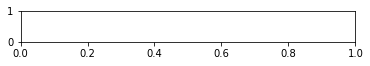

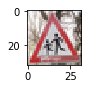

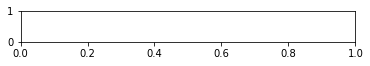

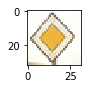

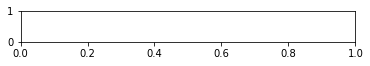

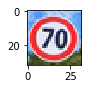

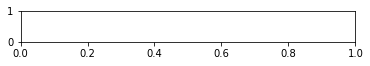

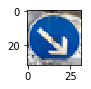

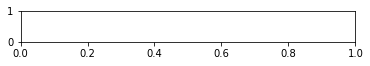

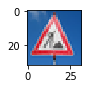

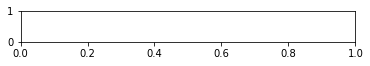

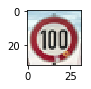

In [15]:
### Load the images , show them and preprocess then.
# every image should do grayscale, local histogram equalize and normalize

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

import os
import cv2
import numpy as np

X_image_set = []

i = 0
for img_name in os.listdir('images/'):
    img = cv2.imread('images/' + img_name)
    plt.figure(figsize=(1,1))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    img = clahe.apply(img)
    X_image_set.append(img)

num_of_image_set = len(X_image_set)
    
X_image_set = np.array(X_image_set).reshape(num_of_image_set, 32, 32, 1)

In [ ]:
# test_image_set[0] = cv2.cvtColor(test_image_set[0], cv2.COLOR_RGB2GRAY)
# in order to use local equalization, we need to first convert image dtype to uint8

X_image_set = X_image_set.astype('float32')
X_image_set = normalize_dataset(X_image_set)
print(X_image_set.dtype)

In [ ]:
plt.imshow(X_image_set[5].squeeze(), cmap='gray')

In [ ]:
k = 5

predictions = tf.nn.softmax(logits)
top_k_predictions = tf.nn.top_k(predictions, k)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    tf.train.Saver().restore(sess, tf.train.latest_checkpoint('record'))

    
    p = sess.run(top_k_predictions, feed_dict = {
        x : X_image_set, keep_prob_conv1: 1.0, keep_prob_conv2: 1.0, keep_prob_conv3: 1.0, keep_prob_fc1: 1.0
        }
    )

# predictions = predictions[1][:, np.argmax(predictions[0], 1)][:, 0].astype(int)
#     print("yes Accuracy = {:.3f}".format(yes_accuracy))

In [ ]:
from pandas.io.parsers import read_csv

signnames = read_csv("signnames.csv").values[:, 1]

In [ ]:
predictions = p[1][:, np.argmax(p[0], 1)][:, 0].astype(int)

In [ ]:
print(predictions)

In [ ]:
p[0][0]

In [ ]:
val

In [ ]:
X_image_set.shape

In [ ]:
from pylab import *


pos = arange(5)+.5    # the bar centers on the y axis

for i in range(len(X_image_set)):

    val = p[0][i]         # the bar lengths
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 3))
    
    print("Class {}: {}".format(y_image_set[i], signnames[y_image_set[i]]))
    axes[0].imshow(X_image_set[i].squeeze(), cmap='gray')
    axes[1].barh(pos,val, align='center')
    axes[1].set_yticks(pos)
    axes[1].set_yticklabels(signnames[p[1][i]])
    
    plt.show()

### Load model variable

In [ ]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('record'))

    train_accuracy = evaluate(X_train, y_train)
    print("Train Accuracy = {:.3f}".format(train_accuracy))
    
    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))
    

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")